# Deep Learning Model Iteration Process on the MNIST Dataset Using Keras - Ken Chua

The MNIST dataset is a set of tens of thousands of images of labeled handwritten digits 0-9. The task for the classifier is to look at the images and output what number it sees. Here is a sampling of the dataset:

<img src="https://files.readme.io/DhKHDNzS0OJhH2uiMOkl_mnist.png"/>

Let's start with a single fully connected layer as our baseline network.

In [184]:
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
from keras import Model
from keras.layers import BatchNormalization, Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D, Softmax
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical

In [97]:
np.random.seed(0)

In [98]:
DATASETS_DIR = "/datasets/"
IMAGE_WIDTH = 28
TRAIN_X_COUNT = 50000
DEV_X_COUNT = 10000
TEST_X_COUNT = 10000
CHANNEL_COUNT = 1
CLASSES_COUNT = 10
BLACK = 255
BATCH_SIZE = 512
EPOCHS=50

In [99]:
def load_mnist():
    IMAGES_FILE_HEADER_SIZE = 16
    LABELS_FILE_HEADER_SIZE = 8

    train_x = np.fromfile(DATASETS_DIR + "train-images.idx3-ubyte", dtype=np.uint8)
    train_x = train_x[IMAGES_FILE_HEADER_SIZE:]
    train_x = train_x.reshape((TRAIN_X_COUNT+DEV_X_COUNT, IMAGE_WIDTH, IMAGE_WIDTH, CHANNEL_COUNT)).astype(float)
    dev_x = train_x[:DEV_X_COUNT]
    train_x = train_x[DEV_X_COUNT:]

    train_y = np.fromfile(DATASETS_DIR + "train-labels.idx1-ubyte", dtype=np.uint8)[LABELS_FILE_HEADER_SIZE:]
    dev_y = train_y[:DEV_X_COUNT]
    train_y = train_y[DEV_X_COUNT:]

    test_x = np.fromfile(DATASETS_DIR + "t10k-images.idx3-ubyte", dtype=np.uint8)
    test_x = test_x[IMAGES_FILE_HEADER_SIZE:]
    test_x = test_x.reshape((TEST_X_COUNT, IMAGE_WIDTH, IMAGE_WIDTH, CHANNEL_COUNT)).astype(float)

    test_y = np.fromfile(DATASETS_DIR + "t10k-labels.idx1-ubyte", dtype=np.uint8)[LABELS_FILE_HEADER_SIZE:]

    return train_x, train_y, dev_x, dev_y, test_x, test_y

In [100]:
def normalize(xs):
    return xs/BLACK

In [101]:
train_x, train_y, dev_x, dev_y, test_x, test_y = load_mnist()

train_x = normalize(train_x)
dev_x = normalize(dev_x)
test_x = normalize(test_x)
train_y = to_categorical(train_y, CLASSES_COUNT)
dev_y = to_categorical(dev_y, CLASSES_COUNT)
test_y = to_categorical(test_y, CLASSES_COUNT)

In [102]:
def model_dense():
    X_input = Input(shape=(IMAGE_WIDTH*IMAGE_WIDTH,))
    X = Dense(CLASSES_COUNT)(X_input)
    X = Softmax()(X)
    return Model(inputs=X_input, outputs=X)

In [137]:
def plot_accuracy(history, title, validation_set_label):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.tick_params(axis='y', which='both', labelleft=True, labelright=True)
    plt.legend(['Training set', validation_set_label], loc='right')
    plt.show()

In [104]:
baseline_model = model_dense()
baseline_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
baseline_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 10)                7850      
_________________________________________________________________
softmax_25 (Softmax)         (None, 10)                0         
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [105]:
baseline_model_history = baseline_model.fit(x=train_x.reshape((TRAIN_X_COUNT, IMAGE_WIDTH*IMAGE_WIDTH)),
                                            y=train_y,
                                            batch_size=BATCH_SIZE,
                                            epochs=EPOCHS,
                                            validation_data=(dev_x.reshape((DEV_X_COUNT, IMAGE_WIDTH*IMAGE_WIDTH)),
                                                             dev_y),
                                            shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 1s 21us/step - loss: 1.1727 - acc: 0.7173 - val_loss: 0.6874 - val_acc: 0.8462
Epoch 2/50
50000/50000 [==============================] - 1s 12us/step - loss: 0.5836 - acc: 0.8633 - val_loss: 0.4954 - val_acc: 0.8782
Epoch 3/50
50000/50000 [==============================] - 1s 11us/step - loss: 0.4639 - acc: 0.8831 - val_loss: 0.4222 - val_acc: 0.8917
Epoch 4/50
50000/50000 [==============================] - 1s 12us/step - loss: 0.4087 - acc: 0.8934 - val_loss: 0.3830 - val_acc: 0.8999
Epoch 5/50
50000/50000 [==============================] - 1s 12us/step - loss: 0.3765 - acc: 0.9000 - val_loss: 0.3579 - val_acc: 0.9037
Epoch 6/50
50000/50000 [==============================] - 1s 11us/step - loss: 0.3546 - acc: 0.9055 - val_loss: 0.3418 - val_acc: 0.9082
Epoch 7/50
50000/50000 [==============================] - 1s 11us/step - loss: 0.3389 - acc: 0.9088 - val_loss: 0.3301 - val_acc

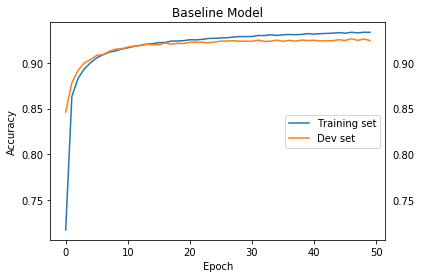

In [185]:
plot_accuracy(baseline_model_history, 'Baseline Model', 'Dev set')

The baseline model - a single fully connected layer - achieves a training set accuracy of 93% and a dev set accuracy of 92%. Let's assume human-level performance is 100% accuracy. This means the avoidable bias of this model is 100% - 93% = 7%, and variance is 93% - 92% = 1%. Since avoidable bias is bigger, it would be best to focus on reducing that to improve the performance of our network most quickly.

Let's try a more complex network - a convolutional neural network (CNN).

In [107]:
def model_single_layer_cnn():
    X_input = Input(shape=(IMAGE_WIDTH, IMAGE_WIDTH, 1))
    X = Conv2D(filters=15, kernel_size=4, activation='elu')(X_input)
    X = Flatten()(X)
    X = Dense(CLASSES_COUNT)(X)
    X = Softmax()(X)
    return Model(inputs=X_input, outputs=X)

In [108]:
cnn_model1 = model_single_layer_cnn()
cnn_model1.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 25, 25, 15)        255       
_________________________________________________________________
flatten_24 (Flatten)         (None, 9375)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 10)                93760     
_________________________________________________________________
softmax_26 (Softmax)         (None, 10)                0         
Total params: 94,015
Trainable params: 94,015
Non-trainable params: 0
_________________________________________________________________


In [109]:
cnn_model1_history = cnn_model1.fit(x=train_x, y=train_y, batch_size=BATCH_SIZE, epochs=EPOCHS,
                                    validation_data=(dev_x, dev_y), shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 1s 27us/step - loss: 0.5344 - acc: 0.8557 - val_loss: 0.3075 - val_acc: 0.9137
Epoch 2/50
50000/50000 [==============================] - 1s 14us/step - loss: 0.3007 - acc: 0.9135 - val_loss: 0.2866 - val_acc: 0.9210
Epoch 3/50
50000/50000 [==============================] - 1s 15us/step - loss: 0.2821 - acc: 0.9202 - val_loss: 0.2722 - val_acc: 0.9225
Epoch 4/50
50000/50000 [==============================] - 1s 14us/step - loss: 0.2680 - acc: 0.9237 - val_loss: 0.2735 - val_acc: 0.9222
Epoch 5/50
50000/50000 [==============================] - 1s 14us/step - loss: 0.2543 - acc: 0.9292 - val_loss: 0.2524 - val_acc: 0.9293
Epoch 6/50
50000/50000 [==============================] - 1s 15us/step - loss: 0.2397 - acc: 0.9329 - val_loss: 0.2465 - val_acc: 0.9296
Epoch 7/50
50000/50000 [==============================] - 1s 15us/step - loss: 0.2220 - acc: 0.9378 - val_loss: 0.2280 - val_acc

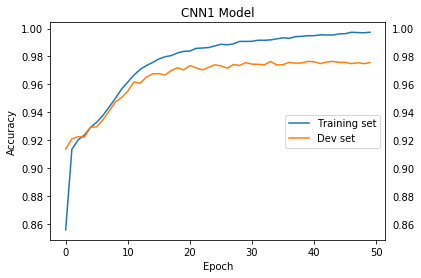

In [139]:
plot_accuracy(cnn_model1_history, 'CNN1 Model', 'Dev set')

This model achieves 99.7% accuracy on the training set and 97.5% accuracy on the dev set. This gives us 0.3% avoidable bias (100% - 99.7%) and 2.2% variance (99.7% - 97.5%). Now variance is the larger factor, so let's focus on reducing it.

One way we can try to reduce variance is by adding dropout after the Conv2D layer. After settling on a dropout rate of 0.2, I achieved 98.0% accuracy on the dev set. Adding another Conv2D layer and another Dropout layer got me even a bit higher, to 98.4%.

In [111]:
def model_double_layer_cnn():
    X_input = Input(shape=(IMAGE_WIDTH, IMAGE_WIDTH, 1))
    X = Conv2D(filters=15, kernel_size=4, activation='elu')(X_input)
    X = Dropout(0.2)(X)
    X = Conv2D(filters=50, kernel_size=4, strides=2, activation='elu')(X)
    X = Flatten()(X)
    X = Dropout(0.2)(X)
    X = Dense(CLASSES_COUNT)(X)
    X = Softmax()(X)
    return Model(inputs=X_input, outputs=X)

In [112]:
cnn_model2 = model_double_layer_cnn()
cnn_model2.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 25, 25, 15)        255       
_________________________________________________________________
dropout_26 (Dropout)         (None, 25, 25, 15)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 11, 11, 50)        12050     
_________________________________________________________________
flatten_25 (Flatten)         (None, 6050)              0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 6050)              0         
_________________________________________________________________
dense_27 (Dense)             (None, 10)                60510     
__________

In [113]:
cnn_model2_history = cnn_model2.fit(x=train_x, y=train_y, batch_size=BATCH_SIZE, epochs=EPOCHS,
                                    validation_data=(dev_x, dev_y), shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 2s 34us/step - loss: 0.5485 - acc: 0.8486 - val_loss: 0.2993 - val_acc: 0.9146
Epoch 2/50
50000/50000 [==============================] - 1s 21us/step - loss: 0.2886 - acc: 0.9167 - val_loss: 0.2402 - val_acc: 0.9316
Epoch 3/50
50000/50000 [==============================] - 1s 21us/step - loss: 0.2038 - acc: 0.9413 - val_loss: 0.1516 - val_acc: 0.9582
Epoch 4/50
50000/50000 [==============================] - 1s 20us/step - loss: 0.1281 - acc: 0.9625 - val_loss: 0.1075 - val_acc: 0.9701
Epoch 5/50
50000/50000 [==============================] - 1s 21us/step - loss: 0.0981 - acc: 0.9707 - val_loss: 0.0940 - val_acc: 0.9732
Epoch 6/50
50000/50000 [==============================] - 1s 20us/step - loss: 0.0836 - acc: 0.9740 - val_loss: 0.0794 - val_acc: 0.9773
Epoch 7/50
50000/50000 [==============================] - 1s 21us/step - loss: 0.0725 - acc: 0.9777 - val_loss: 0.0814 - val_acc

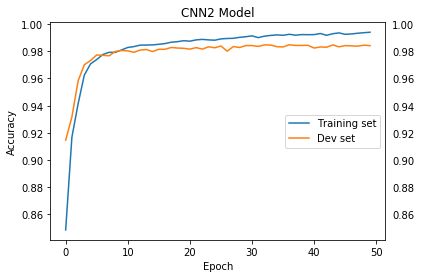

In [140]:
plot_accuracy(cnn_model2_history, 'CNN2 Model', 'Dev set')

We have lost some training accuracy (down to 99.4% from 99.7%) due to our Dropout layers in exchange for better performance on our dev set (up to 98.4% from 97.5%).

We can probably do better with an even more complex network. Let's try adding another Conv2D layer, as well as pooling and batch normalization layers.

In [179]:
def model_triple_layer_cnn():
    X_input = Input(shape=(IMAGE_WIDTH, IMAGE_WIDTH, 1))
    X = Conv2D(filters=15, kernel_size=3, activation='elu')(X_input)
    X = MaxPooling2D(2)(X)
    X = BatchNormalization()(X)
    X = Dropout(0.2)(X)
    X = Conv2D(filters=30, kernel_size=4, activation='elu')(X)
    X = MaxPooling2D(2)(X)
    X = BatchNormalization()(X)
    X = Dropout(0.2)(X)
    X = Conv2D(filters=50, kernel_size=5, activation='elu')(X)
    X = Flatten()(X)
    X = BatchNormalization()(X)
    X = Dropout(0.2)(X)
    X = Dense(CLASSES_COUNT)(X)
    X = Softmax()(X)
    return Model(inputs=X_input, outputs=X)

In [180]:
cnn_model3 = model_triple_layer_cnn()
cnn_model3.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 26, 26, 15)        150       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 13, 13, 15)        0         
_________________________________________________________________
batch_normalization_40 (Batc (None, 13, 13, 15)        60        
_________________________________________________________________
dropout_69 (Dropout)         (None, 13, 13, 15)        0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 10, 10, 30)        7230      
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 5, 5, 30)          0         
__________

In [181]:
cnn_model3_history = cnn_model3.fit(x=train_x, y=train_y, batch_size=BATCH_SIZE, epochs=EPOCHS,
                                    validation_data=(dev_x, dev_y), shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 75us/step - loss: 0.4844 - acc: 0.8531 - val_loss: 0.3850 - val_acc: 0.8857
Epoch 2/50
50000/50000 [==============================] - 1s 28us/step - loss: 0.1675 - acc: 0.9523 - val_loss: 0.4371 - val_acc: 0.8738
Epoch 3/50
50000/50000 [==============================] - 1s 28us/step - loss: 0.1138 - acc: 0.9674 - val_loss: 0.3531 - val_acc: 0.8978
Epoch 4/50
50000/50000 [==============================] - 1s 27us/step - loss: 0.0932 - acc: 0.9722 - val_loss: 0.1393 - val_acc: 0.9578
Epoch 5/50
50000/50000 [==============================] - 1s 28us/step - loss: 0.0798 - acc: 0.9762 - val_loss: 0.0892 - val_acc: 0.9716
Epoch 6/50
50000/50000 [==============================] - 1s 27us/step - loss: 0.0704 - acc: 0.9787 - val_loss: 0.0877 - val_acc: 0.9724
Epoch 7/50
50000/50000 [==============================] - 1s 27us/step - loss: 0.0635 - acc: 0.9812 - val_loss: 0.0504 - val_acc

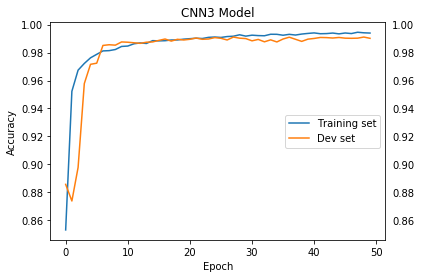

In [182]:
plot_accuracy(cnn_model3_history, 'CNN3 Model', 'Dev set')

All right, we have achieved 99.0% dev set accuracy.

Finally, let's see how we do on the test set.

In [183]:
cnn_model3.evaluate(x=test_x, y=test_y, batch_size=BATCH_SIZE)[1]

10000/10000 [==============================] - 0s 12us/step


0.9932999998092651

We do even better on our test set - 99.3% accuracy.